# Setup

## Imports

In [ ]:
import gensim.downloader as api

from wefe.datasets import fetch_debiaswe, load_weat
from wefe.debias.hard_debias import HardDebias
from wefe.metrics import WEAT
from wefe.query import Query
from wefe.word_embedding_model import WordEmbeddingModel

import utils
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches


plt.style.use('ggplot')

spoke_colors = ['#FFC1C1', '#49486C', '#D0DFFB', '#FFF2D1']

## Download Dataset

In [ ]:
twitter_25 = api.load("glove-twitter-25")
model = WordEmbeddingModel(twitter_25, "glove-twitter-dim=25")

In [ ]:
utils.list_all_pretrained_models()

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


# Hard Debias

**Example of gender debiasing**

The gender-neutral terms, should be equidistant to the he-she pairs, and the gender-specific terms should continue to convey the embedded gender information in them.

* SVD (singular value decomposition) as performed on a subset of such opposite gender pairs, to finally obtain the direction or subspace of this bias
* The vectors lying in this subspace (the gender-neutral terms) are “neutralized” such that they remain equidistant from equality pairs like “he-she”. Technically, what happens is that the projection of the embedding on the bias direction is subtracted from the vector

* The embeddings outside this direction (the gender-specific terms) are “equalized”, or averaged out to have the same vector length. This is done to ensure that the neutral terms are equidistant to ALL equality pairs. For example, the term doctor should be equidistant to both guy-girl and man-woman.



Some important Parameters:

* criterion_name: name to give de-biased model
* target: If a set of words is specified in target, the debias method will be performed only on the word embeddings associated with this set.
* ignore: these set of words are not debiased (e.g. maintain their gendered meaning)

In [ ]:
debiaswe_wordsets = fetch_debiaswe()

definitional_pairs = debiaswe_wordsets["definitional_pairs"]
print(f'definitional_pairs: {definitional_pairs}')

equalize_pairs = debiaswe_wordsets["equalize_pairs"]
print(f"equalize_pairs: {equalize_pairs}")

gender_specific = debiaswe_wordsets["gender_specific"]
print(f"gender_specific: {gender_specific}")

hd = HardDebias(verbose=False, criterion_name="gender").fit(
    model,
    definitional_pairs=definitional_pairs,
    equalize_pairs=equalize_pairs,
)

definitional_pairs: [['woman', 'man'], ['girl', 'boy'], ['she', 'he'], ['mother', 'father'], ['daughter', 'son'], ['gal', 'guy'], ['female', 'male'], ['her', 'his'], ['herself', 'himself'], ['Mary', 'John']]
equalize_pairs: [['monastery', 'convent'], ['spokesman', 'spokeswoman'], ['Catholic_priest', 'nun'], ['Dad', 'Mom'], ['Men', 'Women'], ['councilman', 'councilwoman'], ['grandpa', 'grandma'], ['grandsons', 'granddaughters'], ['prostate_cancer', 'ovarian_cancer'], ['testosterone', 'estrogen'], ['uncle', 'aunt'], ['wives', 'husbands'], ['Father', 'Mother'], ['Grandpa', 'Grandma'], ['He', 'She'], ['boy', 'girl'], ['boys', 'girls'], ['brother', 'sister'], ['brothers', 'sisters'], ['businessman', 'businesswoman'], ['chairman', 'chairwoman'], ['colt', 'filly'], ['congressman', 'congresswoman'], ['dad', 'mom'], ['dads', 'moms'], ['dudes', 'gals'], ['ex_girlfriend', 'ex_boyfriend'], ['father', 'mother'], ['fatherhood', 'motherhood'], ['fathers', 'mothers'], ['fella', 'granny'], ['fraternity

In [ ]:
debiaswe_wordsets.keys()

dict_keys(['male_terms', 'female_terms', 'definitional_pairs', 'equalize_pairs', 'gender_specific', 'professions'])

In [ ]:
debiaswe_wordsets

{'male_terms': ['woman',
  'girl',
  'she',
  'mother',
  'daughter',
  'gal',
  'female',
  'her',
  'herself',
  'Mary'],
 'female_terms': ['man',
  'boy',
  'he',
  'father',
  'son',
  'guy',
  'male',
  'his',
  'himself',
  'John'],
 'definitional_pairs': [['woman', 'man'],
  ['girl', 'boy'],
  ['she', 'he'],
  ['mother', 'father'],
  ['daughter', 'son'],
  ['gal', 'guy'],
  ['female', 'male'],
  ['her', 'his'],
  ['herself', 'himself'],
  ['Mary', 'John']],
 'equalize_pairs': [['monastery', 'convent'],
  ['spokesman', 'spokeswoman'],
  ['Catholic_priest', 'nun'],
  ['Dad', 'Mom'],
  ['Men', 'Women'],
  ['councilman', 'councilwoman'],
  ['grandpa', 'grandma'],
  ['grandsons', 'granddaughters'],
  ['prostate_cancer', 'ovarian_cancer'],
  ['testosterone', 'estrogen'],
  ['uncle', 'aunt'],
  ['wives', 'husbands'],
  ['Father', 'Mother'],
  ['Grandpa', 'Grandma'],
  ['He', 'She'],
  ['boy', 'girl'],
  ['boys', 'girls'],
  ['brother', 'sister'],
  ['brothers', 'sisters'],
  ['business

## Saving Debiased Model

In [ ]:
gender_debiased_model = hd.transform(model, ignore=gender_specific, copy=True)

Copy argument is True. Transform will attempt to create a copy of the original model. This may fail due to lack of memory.
Model copy created successfully.
100%|██████████| 1193514/1193514 [00:16<00:00, 73058.60it/s]


# Mesuring & Visualising Impact of Debiasing 

## Measuring Bias

In [ ]:
weat_wordset = load_weat()
weat = WEAT()

gender_query_1 = Query(
    [weat_wordset["male_terms"], weat_wordset["female_terms"]],
    [weat_wordset["career"], weat_wordset["family"]],
    ["Male terms", "Female terms"],
    ["Career", "Family"],
)


In [ ]:
biased_results_1 = weat.run_query(gender_query_1, model, normalize=True)
debiased_results_1 = weat.run_query(gender_query_1, gender_debiased_model, normalize=True)
result_df = pd.DataFrame([biased_results_1, debiased_results_1])
result_df = result_df.assign(model = ['glove-twitter-25', 'glove-twitter-25-unbiased'])
result_df


,query_name,result,weat,effect_size,p_value,model
0,Male terms and Female terms wrt Career and Family,0.316584,0.316584,0.677944,NaN,glove-twitter-25
1,Male terms and Female terms wrt Career and Family,-0.060435,-0.060435,-0.188125,NaN,glove-twitter-25-unbiased


## Visualising

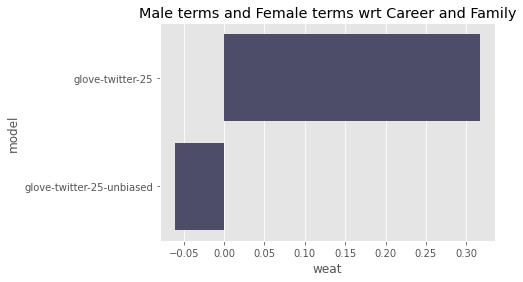

In [ ]:
sns.barplot(x = "weat", y = "model", data = result_df, color=spoke_colors[1])
plt.title(result_df['query_name'][0])
plt.show()

# Exercises

1. Debias a word-embedding of your choice for bias of your choosing and visualise the results 
2. Discuss potential issues with this method of bias mitigation and explain in a couple of sentences

In [ ]:
WEAT

wefe.metrics.WEAT.WEAT

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d2871a92-4e31-4482-a3e9-30cad94e9005' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>